# Анализ данных

In [1]:
import pandas as pd

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_all = pd.concat([df_train, df_test], ignore_index=True)
df_train_original = df_train.copy()
df_test_original = df_test.copy()
df_all_original = df_all.copy()

In [2]:
df_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [4]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


Рассмотрим список фич:
- PassengerId - в формате *gggg_pp*, где *gggg* - номер группы, а *pp* - номер человека внутри этой группы. Чаще всего люди из одной группы - семья.
- HomePlanet - планета вылета, чаще всего является местом проживания.
- CryoSleep - был ли помещен в крио сон на протяжении полета. Если был, то из кабины никогда не выходил.
- Cabin - каюта в формате *deck/num/side*, где *side* - либо *P (port)*, либо *S (starboard)*.
- Destination - место назначения.
- Age - возраст.
- VIP - вип или не вип.
- RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - сколько денег было потрачено на соответсвующие услуги.
- Name - имя, фамилия
- **Transported** - таргет, был ли перевезен в другое измерение.

Уже сейчас понятно, что нужно будет как минимум распарсить некоторые признаки в отдельные столбцы, в том числе могут пригодиться данные из PassangerId. Для начала этим и займемся.

In [5]:
def parse_base_features(df):
    df = df.copy()
    df['Group'] = df['PassengerId'].str.split('_').str[0]
    df['GNum'] = df['PassengerId'].str.split('_').str[1]
    df['Deck'] = df['Cabin'].str.split('/').str[0]
    df['CNum'] = df['Cabin'].str.split('/').str[1]
    df['Side'] = df['Cabin'].str.split('/').str[2]
    df['FName'] = df['Name'].str.split().str[0]
    df['SName'] = df['Name'].str.split().str[1]
    return df

df_train = parse_base_features(df_train)
df_test = parse_base_features(df_test)
df_all = parse_base_features(df_all)

Теперь можно вывести распределение признаков, что даст нам некоторое понимание данных.

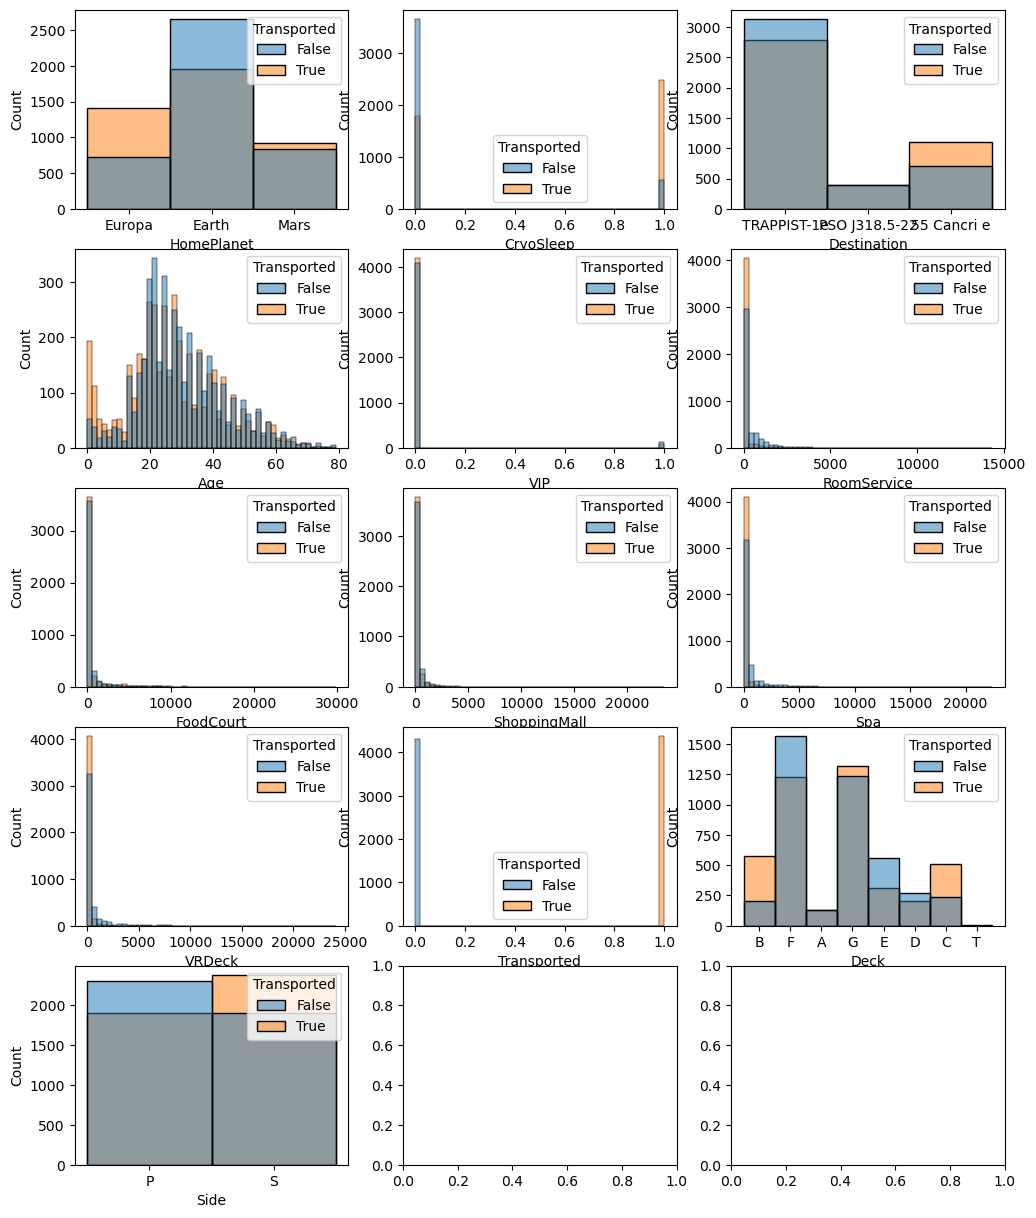

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(5, 3, figsize=(12, 15))
num = 0
for col in df_train.columns.to_list():
    if not (col in {'PassengerId', 'Cabin', 'Name', 'Group', 'GNum', 'CNum', 'FName', 'SName'}):
        sns.histplot(data=df_train, x=col, hue='Transported', bins=50, ax=axes[num // 3, num % 3])
        num += 1
plt.show()

По графикам признаков дополнительных трат можно видеть, что большинство людей не тратили деньги, из-за этого оценить распределение по скошенному графику невозможно. Поэтому построим отдельные логарифмированные графики для этих признаков без учёта нулей.

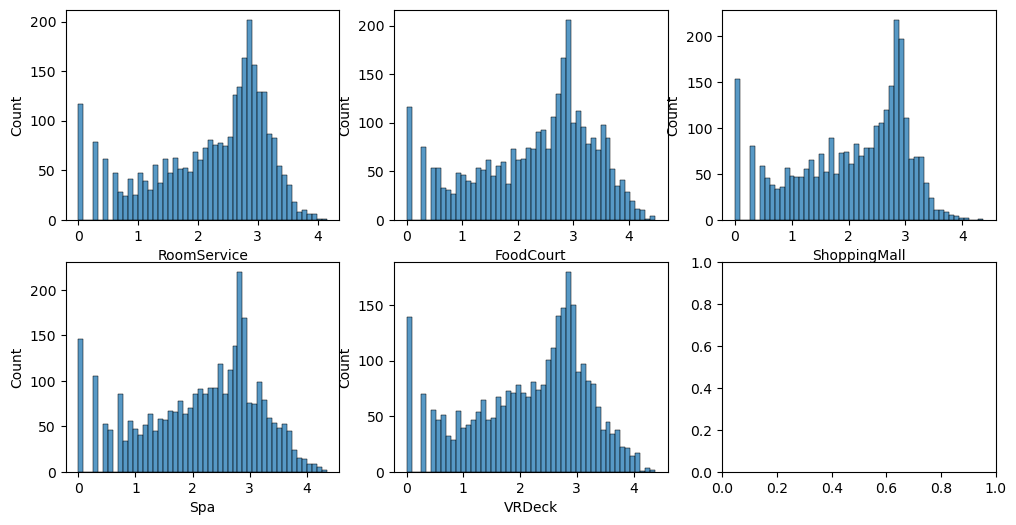

In [7]:
import numpy as np

fig, axes = plt.subplots(2, 3, figsize=(12, 6))
for num, col in enumerate(['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']):
    sns.histplot(x=np.log10(df_train[col][df_train[col] > 0]), bins=50, ax=axes[num // 3, num % 3])
plt.show()

Мы видим, что есть два пика - у нуля и у ~2.8, то есть, если и тратили деньги, то либо почти 0, либо около $10^{2.8}=630$. Сразу возникает предположение, что больше тратили люди обеспеченные, и вероятно они с большей вероятностью выжили. Проверим это на графиках.

Для этого снова построим гистограммы, но на одном графике отобразим статистику для Transported True и для False. Это делается с помощью параметра hue, по сути это как groupby. Кроме того, используем режим наложения multiple='fill'. В этом режиме можно каждый столбец отображается как 100%, так что можно видеть какую долю спасенные составляют от людей в бине. Если столбец наполовину синий, а наполовину оранжевый, значит True и False поровну. Если синяя часть занимает 80% столбца, а оранжевая 20%, значит от общего числа значений в бине 80% False, а True 20%.

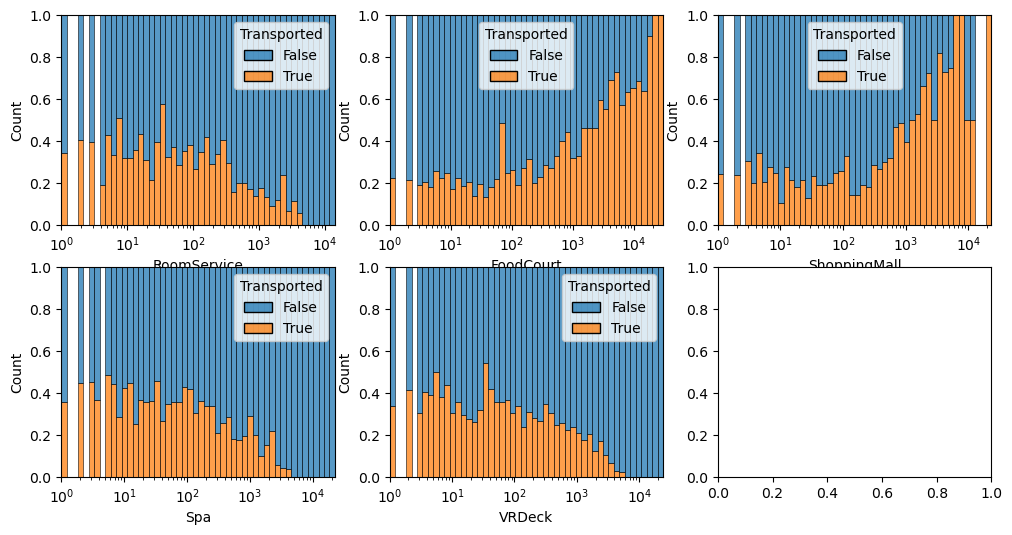

In [8]:
fix, axes = plt.subplots(2, 3, figsize=(12, 6))
for num, col in enumerate(['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']):
    sns.histplot(data=df_train[df_train[col]>0], x=col, hue='Transported', log_scale=True, multiple='fill', bins=50, ax=axes[num // 3, num % 3])
plt.show()

Что интересно, на данных графиках не видно особых совпадений пиков с пиками из предыдущих графиков. То есть гипотеза, что те, кто тратил больше, выживали чаще, не совсем верна. Можно видеть, что в общем объем трат не особо влияет на выживаемость, кроме крупных значений трат. Если смотреть на большие объемы трат, идущие после второго пика общего распределения признака, то чем больше тратишься на RoomService, Spa и VRDeck, тем меньше шансов выжить. И наоброт с FoorCourt и ShoppingMall.

Это неплохое наблюдение. Оно сразу говорит нам о том, что очевидная идея создать столбец общих трат будет плохой, так как такой столбец объединит противоположные по знаку друг другу признаки. Возможно стоит создать столбцы RoomService + Spa + VRDeck и FoodCourt + ShoppingMall.

Пока больше нет идей, каких-то выводов о данных. Поэтому пока займемся заполнением пропусков, потом возможно придумаем еще какие-то новые признаки.

## Заполнение пропусков

### HomePlanet

Не хочется заполнять просто модой - Землей. По графикам выше мы явно видим, что выживаемость зависит от планеты вылета. При вылете с Европы шанс выжить примерно 66%, с Земли 44%, с Марса >50%. А если заполнить Землей, то получится, что у таких строк сразу будет заниженный шанс выживания - и это если еще не нарушится распределение данных.

Есть пара вариантов-гипотез:
1. Если есть кто-то с совпадающим номером группы, то скорее всего они семья, а значит с одной планеты.
    1. Особенно, если их фамилия совпадает.
3. Если никого с совпадающим номером группы нет, то возможно, что людей с одной планеты селили в одинаковые палубы.
    1. Особенно, если и номер каюты совпадает.

Проверим гипотезы. Сначала сгруппируем по группе планеты, и посмотрим есть ли хоть в какой-то группе люди с разных планет. Также сгруппируем по фамилии и по полному номеру каюты.

In [9]:
inconsistent = df_all.groupby('Group')['HomePlanet'].nunique()
print('All in one group from one planet:', inconsistent[inconsistent > 1].empty)
inconsistent = df_all.groupby('SName')['HomePlanet'].nunique()
print('All with one second name from one planet:', inconsistent[inconsistent > 1].empty)
inconsistent = df_all.groupby('Cabin')['HomePlanet'].nunique()
print('All in one cabin from one planet:', inconsistent[inconsistent > 1].empty)

All in one group from one planet: True
All with one second name from one planet: True
All in one cabin from one planet: True


Видим, что в каждой группе все люди с одной планеты. И даже люди с одинаковой фамилией всегда тоже с одной планеты (что вообще-то странно). И люди из одной кабины тоже с одной планеты. Теперь проверим вторую гипотезу, построив распределение планет по каждой палубе.

<Axes: xlabel='Deck', ylabel='count'>

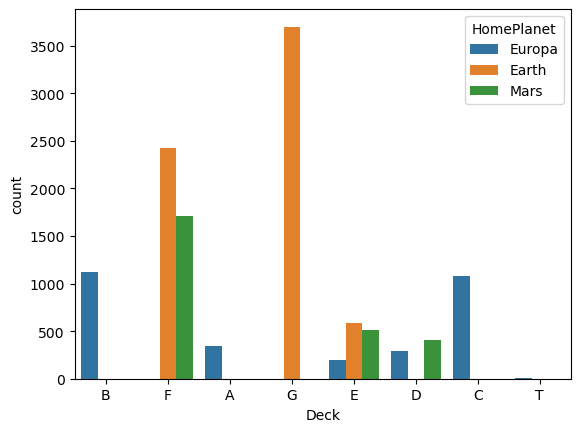

In [10]:
sns.countplot(data=df_all, x='Deck', hue='HomePlanet')

Видим, что на палубе B, A, C и T селили только с Европы, на палубе G только с Земли. Также можем видеть, что на F не селили с Европы, а на D не селили с Земли. Возможно, этого хватит, чтобы однозначно заполнить пропуски. Если не получится, будем думать еще. (Далее вывели численно, а не графически статистику по планетам, сгруппированным по палубе, чтобы подтвердить визуальные наблюдения)

In [11]:
df_all.groupby('Deck')['HomePlanet'].value_counts()

Deck  HomePlanet
A     Europa         346
B     Europa        1124
C     Europa        1081
D     Mars           406
      Europa         296
E     Earth          583
      Mars           508
      Europa         197
F     Earth         2426
      Mars          1713
G     Earth         3700
T     Europa          10
Name: count, dtype: int64

Итак, раз некоторые палубы выступают гарантированным показателем с какой планеты пассажир, и всякий номер группы всегда помогает определить планету вылета, если кто-то в этой же группе есть с известной планетой, то сначала заполним пропуски по группе, а потом по палубе.

In [12]:
def fill_homeplanet(df_all, df):
    df = df.copy()
    # 1. Заполнение пропусков по одинаковым группам
    group_planet_map = df_all[df_all['HomePlanet'].notna()].groupby('Group')['HomePlanet'].first()
    df['HomePlanet'] = df['HomePlanet'].fillna(df['Group'].map(group_planet_map))

    # 2. Заполнение пропусков по однозначным палубам
    df.loc[df['Deck'].isin(['A', 'B', 'C', 'T']), 'HomePlanet'] = 'Europa'
    df.loc[df['Deck'] == 'G', 'HomePlanet'] = 'Earth'

    # 2.A Заполнение по одинаковым каютам
    cabin_planet_map = df_all[df_all['HomePlanet'].notna()].groupby('Cabin')['HomePlanet'].first()
    df['HomePlanet'] = df['HomePlanet'].fillna(df['Cabin'].map(cabin_planet_map))

    # 1.A Заполнение по одинаковым фамилиям (сомнительно, шумно в общем случае, так как фамилии не уникальны, но здесь похоже должно работать)
    sname_planet_map = df_all[df_all['HomePlanet'].notna()].groupby('SName')['HomePlanet'].first()
    df['HomePlanet'] = df['HomePlanet'].fillna(df['SName'].map(sname_planet_map))
    
    # 2.C Заполнение остатков (5 в train, 5 в test) по моде HomePlanet, сгруппированных по Deck
    deck_planet_map = df.groupby('Deck')['HomePlanet'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
    df['HomePlanet'] = df['HomePlanet'].fillna(df['Deck'].map(deck_planet_map))

    # 2.D Заполнение остатков глобальной модой HomePlanet
    df['HomePlanet'] = df['HomePlanet'].fillna('Earth')
    
    return df

df_train = fill_homeplanet(df_all, df_train)
df_test = fill_homeplanet(df_all, df_test)
df_all = fill_homeplanet(df_all, df_all)

В итоге после заполнения пропусков сначала по общей группе, потом по фамилиям, а потом по однозначным палубам, в train осталось 5 пропусков, а в test 5. Их я заполнил модами планет по группам Deck. По-хорошему стоит использовать статистики только из train, то есть считать моду там, а потом уже применять это к обоим датасетам. Но статистики по палубам в данном случае полностью совпадают, так что я не стал усложнять код.

В свою очередь, возникает вопрос по заполнения по одинаковым группам. С одной стороны, если я получал бы в реальной жизни по одному пассажиру для предсказания, я мог бы использовать знания только из train и из предыдущих предсказанных пассажиров, чтобы сравнивать совпадают ли группы этих людей. С другой стороны, если мне поступила сразу вся пачка test, логично, что я могу из всей нее тоже цеплять информацию для сравнения групп.

В общем, я решил делать с "утечкой данных" в даном случае заполнение пропусков, потому что конкретно сейчас мне кажется логичным использовать информацию о группах из всего датасета.

### CryoSleep

Посмотрим как совместно распределен CryoSleep с другими признаками.

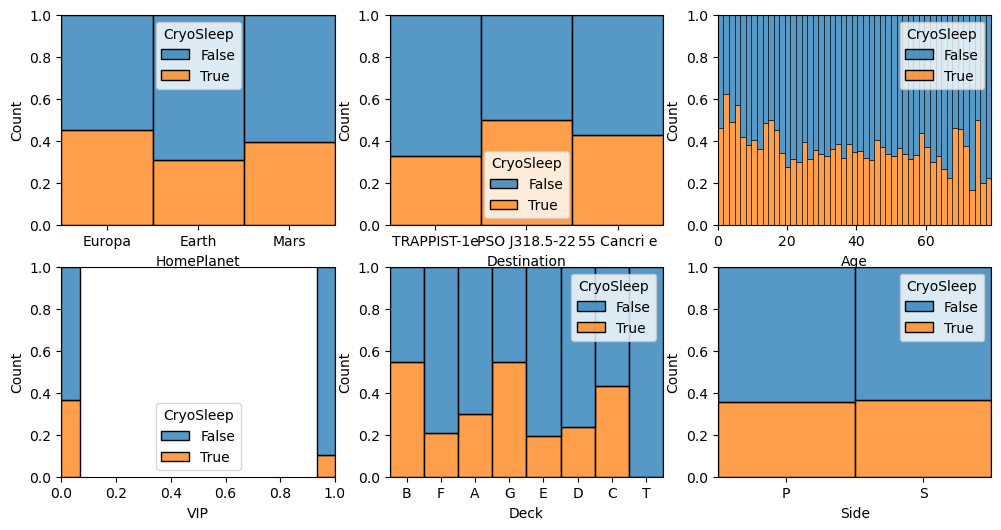

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
for i, col in enumerate(['HomePlanet', 'Destination', 'Age', 'VIP', 'Deck', 'Side']):
    sns.histplot(data=df_all, x=col, hue='CryoSleep', multiple='fill', ax=axes[i // 3, i % 3])
plt.show()

И построим график зависимости CryoSleep от наличия трат.

In [14]:
spending_features = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
df_train['TotalSpendings'] = df_train[spending_features].sum(axis=1)
df_test['TotalSpendings'] = df_test[spending_features].sum(axis=1)
df_all['TotalSpendings'] = df_all[spending_features].sum(axis=1)

<Axes: xlabel='TotalSpendings', ylabel='Count'>

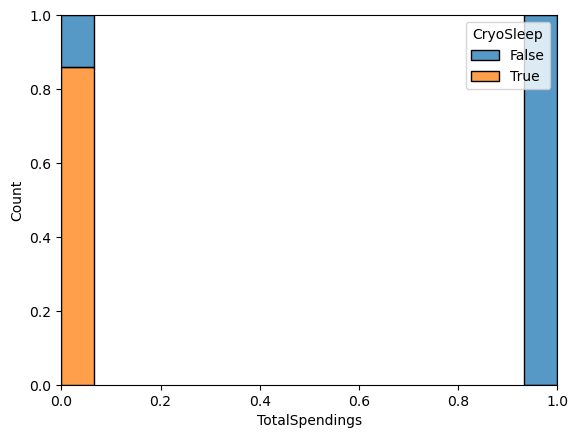

In [15]:
sns.histplot(data=df_all, x=(df_all['TotalSpendings'] > 0), hue='CryoSleep', multiple='fill')

In [16]:
print('VIP and in CryoSleep:', ((df_all['VIP'] == True) & (df_all['CryoSleep'] == True)).sum())
print('VIP and in awake:', ((df_all['VIP'] == True) & (df_all['CryoSleep'] == False)).sum())
print('VIP count:', ((df_all['VIP'] == True) & df_all['CryoSleep'].notna()).sum())

VIP and in CryoSleep: 28
VIP and in awake: 239
VIP count: 267


In [17]:
print('Spent 0 and in CryoSleep:', ((df_all['TotalSpendings'] == 0) & (df_all['CryoSleep'] == True)).sum())
print('Spent 0 and awake:', ((df_all['TotalSpendings'] == 0) & (df_all['CryoSleep'] == False)).sum())
print('Spent 0:', ((df_all['TotalSpendings'] == 0) & (df_all['CryoSleep'].notna())).sum())

Spent 0 and in CryoSleep: 4581
Spent 0 and awake: 740
Spent 0: 5321


Проверим гипотезу, что в одной группе все либо спят, либо не спят. Такую же гипотезу проверим по фамилиям.

In [18]:
inconsistent = df_all.groupby('Group')['CryoSleep'].nunique()
print('Quantity of groups where CryoSleep isn\'t const:', len(inconsistent[inconsistent > 1]))
inconsistent = df_all.groupby('SName')['CryoSleep'].nunique()
print('Quantity of SNames where CryoSleep isn\'t const:', len(inconsistent[inconsistent > 1]))
inconsistent = df_all.groupby(['Group', 'SName'])['CryoSleep'].nunique()

Quantity of groups where CryoSleep isn't const: 1230
Quantity of SNames where CryoSleep isn't const: 1768


Судя по графикам имеем следующие вероятности в порядке убывания:
- Те, кто тратит деньги с вероятностью 1 не в криосне.
- Те, кто ВИП, с вероятностью $\frac{239}{267}=0.9$ не в криосне.
- Те кто, не тратит, имеет вероятность $\frac{4581}{5321}=0.86$ быть в криосне.

Мы можем еще видеть, что в зависимости от палубы вероятность быть в криосне тоже меняется значительно. То есть можно учитывать на какой палубе был человек при заполнении пропусков. Например, все с палубы T не в криосне. Хотя конечно на этой палубе очень мало людей (11), поэтому как самостоятельное правило по типу "тратит деньги -> не спит" такое использовать нельзя. Как вариант, можно попробовать посмотреть на распределение CryoSleep по парам групп (TotalSpendings, Deck) и (VIP, Deck), взять моду.

Гипотезы о том, что все в одной группе или с одной фамилией спят, либо все не спят, не подтвердилась судя по количеству опровержений.

Можно пробовать начинать как-то заполнять пропуски, но давайте еще посмотрим на распределение Transported в зависимости от значения CryoSleep, в том числе при отсутсвии значения. У меня есть гипотеза, что большинство тех, у кого нет информации о криосне, не были транспортированы. Логика такая, что если человек не был спасен и изначально информация о криосне про него была утеряна, то после аварии у него не получится уточнить спал ли он.
<br>
Это граничит с утечкой данных, но я не хочу ошибочно заполнить самый информативный признак, который при значении True почти значит Transported = True.

<Axes: xlabel='CryoSleep', ylabel='count'>

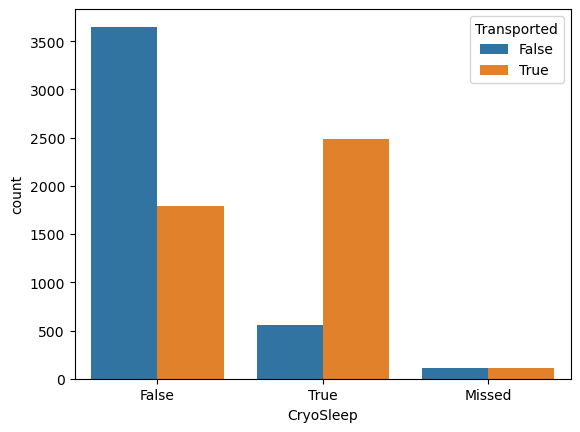

In [19]:
dfka = df_train.copy()
dfka['CryoSleep'] = dfka['CryoSleep'].fillna('Missed')
sns.countplot(data=dfka, x='CryoSleep', hue='Transported')

In [20]:
dfka.groupby('CryoSleep')['Transported'].value_counts()

CryoSleep  Transported
False      False          3650
           True           1789
True       True           2483
           False           554
Missed     False           111
           True            106
Name: count, dtype: int64

Мы видим следующее. Если значение о криосне пропущено, то вероятность выжить составляет 0.5. Это значит, что если я заполню пропуски, то искуственно задам экстремальные шансы выжить или не выжить, в то время как реальные шансы 50%. Логично тогда попробовать заполнить пропуски как третью категорию, которая условно будет означать ноль, так как пропуск должен никак не влиять на предсказание.

Посмотрим как будет выглядеть график, если я заполню очевидные пропуски, где траты больше 0.

<Axes: xlabel='CryoSleep', ylabel='count'>

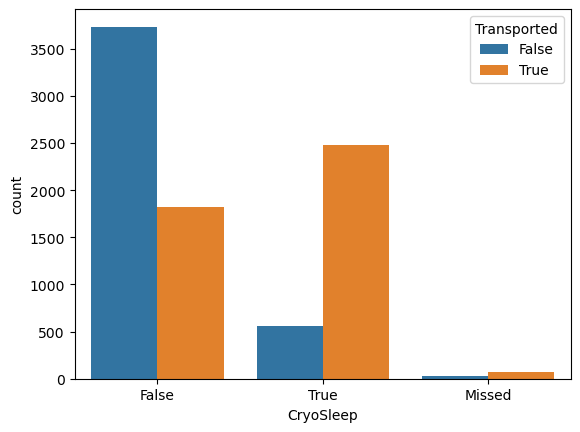

In [21]:
dfka.loc[dfka['TotalSpendings'] > 0, 'CryoSleep'] = False
sns.countplot(data=dfka, x='CryoSleep', hue='Transported')

In [22]:
dfka.groupby('CryoSleep')['Transported'].value_counts()

CryoSleep  Transported
False      False          3734
           True           1824
True       True           2483
           False           554
Missed     True             71
           False            27
Name: count, dtype: int64

Мы видим, что распределение сильно изменилось, теперь у людей с пропущенными CryoSleep шанс выжить 73%. Стоит ли заполнять такие очевидные пропуски или оставить как есть? Я думаю, что стоит заполнить, потому что после этого мы получаем достаточно особенную группу "потратили 0, но неизвестно были ли в криосне". Оставляя очевидные пропуски незаполненными, мы загрязняем группу Missed, так как одно дело создавать группу, о которой мы действительно ничего не знаем, а другое - примешивать к ней данные с гарантированной логикой "кто тратит деньги, тот не спит".

In [23]:
def fill_cryosleep(df):
    df = df.copy()
    df.loc[df['TotalSpendings'] > 0, 'CryoSleep'] = False
    df['CryoSleep'] = df['CryoSleep'].fillna('Missed')
    return df

df_train = fill_cryosleep(df_train)
df_test = fill_cryosleep(df_test)
df_all = fill_cryosleep(df_all)

### RoomService, FoodCourt, ShoppingMall, Spa, VRDeck, TotalSpendings

Первым делом траты всех, кто в криосне, приравняем нулю. Далее перед нами встаёт большое количество столбцов, заполнение которых с анализом может занять большое время. Для простоты можно заполнить пропуски с помощью KNN Imputer, чтобы не анализировать данные.

Но я заполню как всегда медианой по общей группе, потому что хочу для начала попытаться заполнить пропуски, используя анализ данных. Чтобы увидеть, что в одной группе в среднем тратят одинаковое количество денег, посмотрим на среднее по группам стандартное отклонение каждого признака, когда в группе больше одного человека.

In [24]:
spendings_description = df_all.groupby('Group')[spending_features].describe()

In [25]:
print('RoomService mean of std:', spendings_description['RoomService'][spendings_description['RoomService', 'count'] > 1]['std'].mean())
print('FoodCourt mean of std:', spendings_description['FoodCourt'][spendings_description['FoodCourt', 'count'] > 1]['std'].mean())
print('ShoppingMall mean of std:', spendings_description['ShoppingMall'][spendings_description['ShoppingMall', 'count'] > 1]['std'].mean())
print('Spa mean of std:', spendings_description['Spa'][spendings_description['Spa', 'count'] > 1]['std'].mean())
print('VRDeck mean of std:', spendings_description['VRDeck'][spendings_description['VRDeck', 'count'] > 1]['std'].mean())

RoomService mean of std: 285.0025606081622
FoodCourt mean of std: 724.8305191492461
ShoppingMall mean of std: 226.268170742646
Spa mean of std: 486.36442746231177
VRDeck mean of std: 504.40777666653713


Вообще-то отклонение немалое, особенно у FoodCourt, но что поделать в отсутсвие хороших идей.

In [26]:
def fill_spendings(df_all, df):
    df = df.copy()
    # 1. Заполнили нулями всех, кто в криосне
    df.loc[df['CryoSleep'] == True, spending_features] = 0

    # 2. Заполняем медианой по группе
    for col in spending_features:
        group_spending_map = df_all.groupby('Group')[col].median()
        df[col] = df[col].fillna(df['Group'].map(group_spending_map))

    # 3. Заполняем по общему статусу ВИП и палубе
    for col in spending_features:
        vd_spending_map = df_all.groupby(['VIP', 'Deck'])[col].median()
        key = df[['VIP', 'Deck']].apply(tuple, axis=1)
        df[col] = df[col].fillna(key.map(vd_spending_map))
    
    # 4. Глобальная медиана (остатки)
    for col in spending_features:
        df[col] = df[col].fillna(df_all[col].median())

    # 3. Записываем значения в TotalSpendings
    df['TotalSpendings'] = df[spending_features].sum(axis=1)

    return df

df_train = fill_spendings(df_all, df_train)
df_test = fill_spendings(df_all, df_test)
df_all = fill_spendings(df_all, df_all)

### Deck

У палубы такие же связи с другими признаками, что и у планеты вылета: люди из одной группы находятся на одной палубе (и даже скорее всего в одной каюте). Кстати, зато планета вылета никак не может однозначно задать палубу. Если на некоторых палубах находились пассажиры только с одной планеты, то наоборот - все пассажиры с одной планеты на одной палубе - не выполняется.

Попробуем проверить несколько гипотез:
1. Какова доля людей из одной группы на одинаковой палубе?
2. Какова доля людей с одной фамилией на одной палубе?
3. Какова доля людей и из одной группой, и с одной фамилией на одной палубе?
4. Есть ли корреляция палубы с каким-нибудь категориальным признаком?

In [27]:
inconsistent = df_all.groupby('Group')['Deck'].nunique()
print('Same group - same deck:', len(inconsistent[inconsistent == 1]) / len(inconsistent))
inconsistent = df_all.groupby('SName')['Deck'].nunique()
print('Same second name - same deck:', len(inconsistent[inconsistent == 1]) / len(inconsistent))
inconsistent = df_all.groupby(['Group', 'SName'])['Deck'].nunique()
print('Same group and second name - same deck:', len(inconsistent[inconsistent == 1]) / len(inconsistent))
inconsistent = df_all.groupby(['Group', 'HomePlanet'])['Deck'].nunique()
print('Same group and home planet - same deck:', len(inconsistent[inconsistent == 1]) / len(inconsistent))

Same group - same deck: 0.9101293103448276
Same second name - same deck: 0.24023275145469658
Same group and second name - same deck: 0.917890100671141
Same group and home planet - same deck: 0.9101293103448276


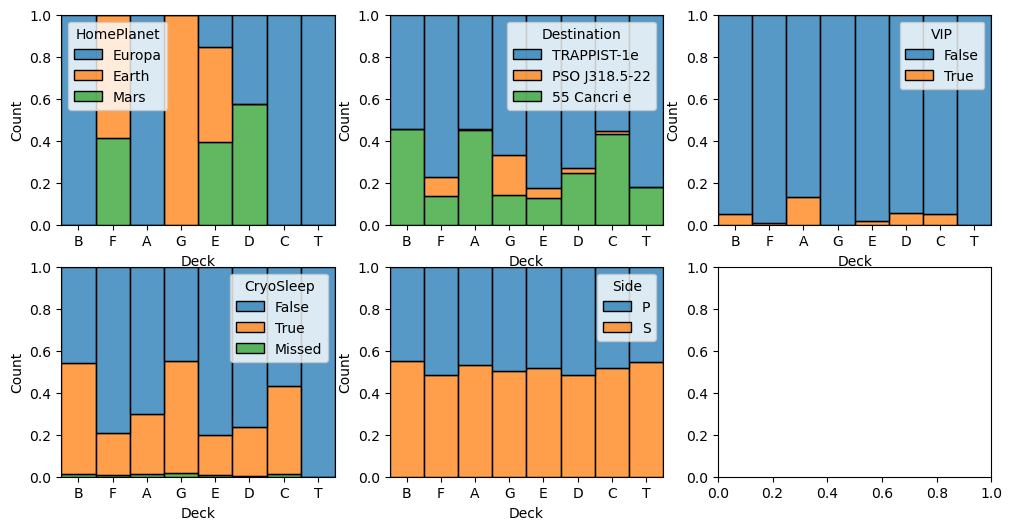

In [28]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
for i, col in enumerate(['HomePlanet', 'Destination', 'VIP', 'CryoSleep', 'Side']):
    sns.histplot(data=df_all, x='Deck', hue=col, multiple='fill', ax=axes[i // 3, i % 3])
plt.show()

Как и ожидалось, люди из одной группы скорее всего на одной палубе. Люди с одной фамилией не коррелируют с палубой. Информация по планете полностью коррелирует с группой, получается группа определяет планету.

Так как больше идей по заполнению пропусков нет, заполним просто по моде в общей группе (учитывать фамилию не будем - прирост мал). Потом заполним остатки модой по планете вылета.

In [29]:
def fill_deck(df_all, df):
    df = df.copy()
    # 1. Заполнение по одинаковым группам
    group_deck_map = df_all.groupby('Group')['Deck'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0])
    df['Deck'] = df['Deck'].fillna(df['Group'].map(group_deck_map))

    # 2. Мода по планете
    planet_deck_map = df_all.groupby('HomePlanet')['Deck'].agg(lambda x: x.mode().iloc[0])
    df['Deck'] = df['Deck'].fillna(df['HomePlanet'].map(planet_deck_map))
    
    return df

df_train = fill_deck(df_all, df_train)
df_test = fill_deck(df_all, df_test)
df_all = fill_deck(df_all, df_all)

### CNum

Вообще, надо проверить может ли номер каюты выступать как *порядковый* числовой признак (вдруг это просто шум):

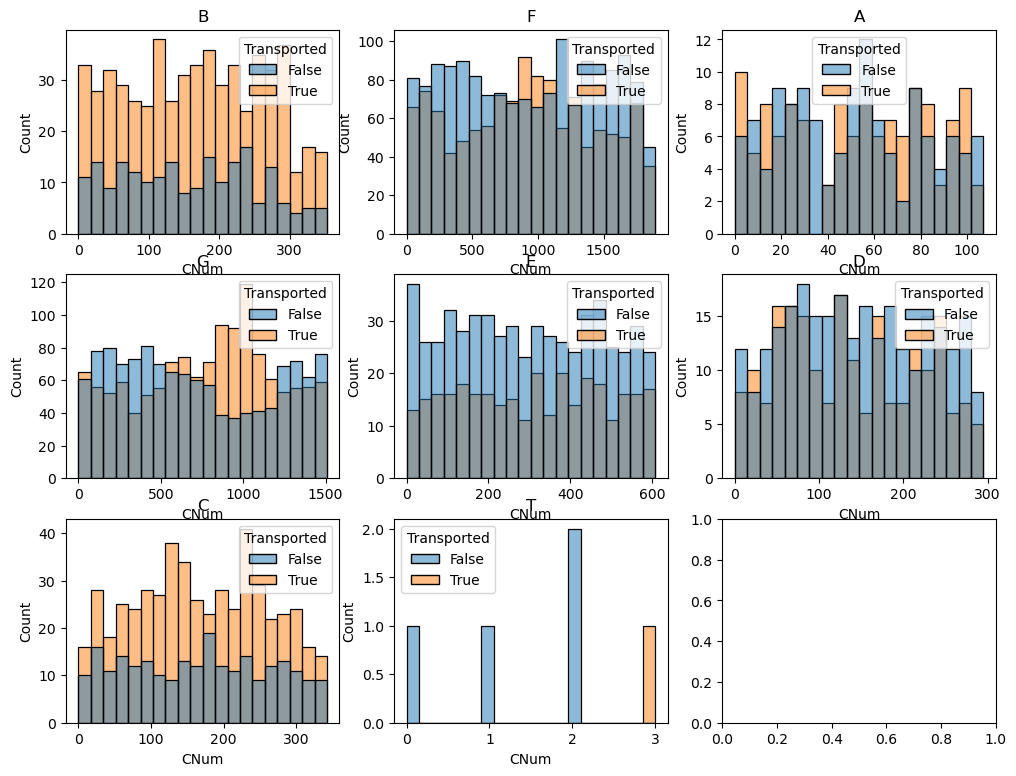

In [30]:
dfka = df_train.copy()
dfka['CNum'] = dfka['CNum'].astype(float)
fig, axes = plt.subplots(3, 3, figsize=(12, 9))
for i, col in enumerate(dfka['Deck'].unique()):
    sns.histplot(data=dfka[dfka['Deck'] == col], x='CNum', hue='Transported', bins=20, ax=axes[i // 3, i % 3])
    axes[i // 3, i % 3].set_title(col)
plt.show()

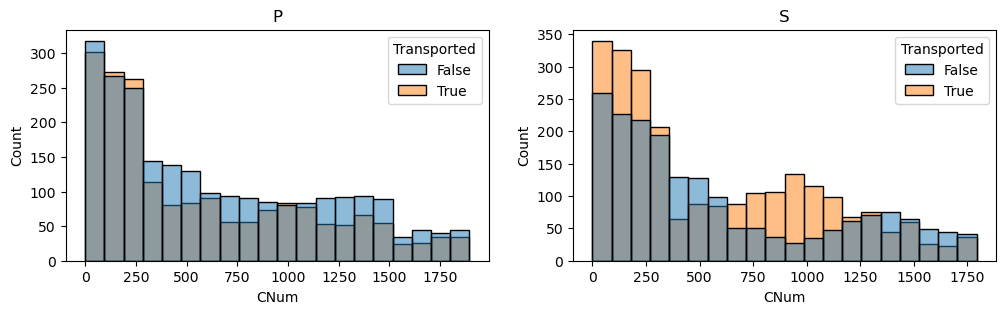

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
for i, col in enumerate(['P', 'S']):
    sns.histplot(data=dfka[dfka['Side'] == col], x='CNum', hue='Transported', bins=20, ax=axes[i])
    axes[i].set_title(col)
plt.show()

Видим, что какая-то зависимость быть спасенным имеется в зависимости от номера каюты, если речь о палубе G, или тем более о стороне S. Так что можем оставить и заполнить пропуски. Но идей для заполнения пропусков не сказать, чтобы было много, да и лень, так что проще выкинуть этот столбец. (Сделаем это позже)

*попытки заполнить, которые я забросил*

In [32]:
'''
inconsistent = df_all.groupby('Group')['CNum'].nunique()
print('Same group - same cabin number:', len(inconsistent[inconsistent == 1]) / len(inconsistent))
inconsistent = df_all.groupby('SName')['CNum'].nunique()
print('Same second name - same cabin number:', len(inconsistent[inconsistent == 1]) / len(inconsistent))
inconsistent = df_all.groupby(['Group', 'SName'])['CNum'].nunique()
print('Same group and second name - same cabin number:', len(inconsistent[inconsistent == 1]) / len(inconsistent))
inconsistent = df_all.groupby(['Group', 'HomePlanet'])['CNum'].nunique()
print('Same group and home planet - same cabin number:', len(inconsistent[inconsistent == 1]) / len(inconsistent))
'''

"\ninconsistent = df_all.groupby('Group')['CNum'].nunique()\nprint('Same group - same cabin number:', len(inconsistent[inconsistent == 1]) / len(inconsistent))\ninconsistent = df_all.groupby('SName')['CNum'].nunique()\nprint('Same second name - same cabin number:', len(inconsistent[inconsistent == 1]) / len(inconsistent))\ninconsistent = df_all.groupby(['Group', 'SName'])['CNum'].nunique()\nprint('Same group and second name - same cabin number:', len(inconsistent[inconsistent == 1]) / len(inconsistent))\ninconsistent = df_all.groupby(['Group', 'HomePlanet'])['CNum'].nunique()\nprint('Same group and home planet - same cabin number:', len(inconsistent[inconsistent == 1]) / len(inconsistent))\n"

In [33]:
'''
def fill_cnum(df_all, df):
    df = df.copy()
    # 1. Заполнение по моде группы
    group_cnum_map = df_all.groupby('Group')['CNum'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0])
    df['CNum'] = df['CNum'].fillna(df['Group'].map(group_cnum_map))

    # 2. Заполнение 

    return df

print(df_all['CNum'].info())
fill_cnum(df_all, df_all)['CNum'].info()
'''

"\ndef fill_cnum(df_all, df):\n    df = df.copy()\n    # 1. Заполнение по моде группы\n    group_cnum_map = df_all.groupby('Group')['CNum'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0])\n    df['CNum'] = df['CNum'].fillna(df['Group'].map(group_cnum_map))\n\n    # 2. Заполнение \n\n    return df\n\nprint(df_all['CNum'].info())\nfill_cnum(df_all, df_all)['CNum'].info()\n"

In [34]:
#df_train = df_train.drop(columns='CNum')
#df_test = df_test.drop(columns='CNum')
#df_all = df_all.drop(columns='CNum')

### Side

<Axes: xlabel='CNum', ylabel='Count'>

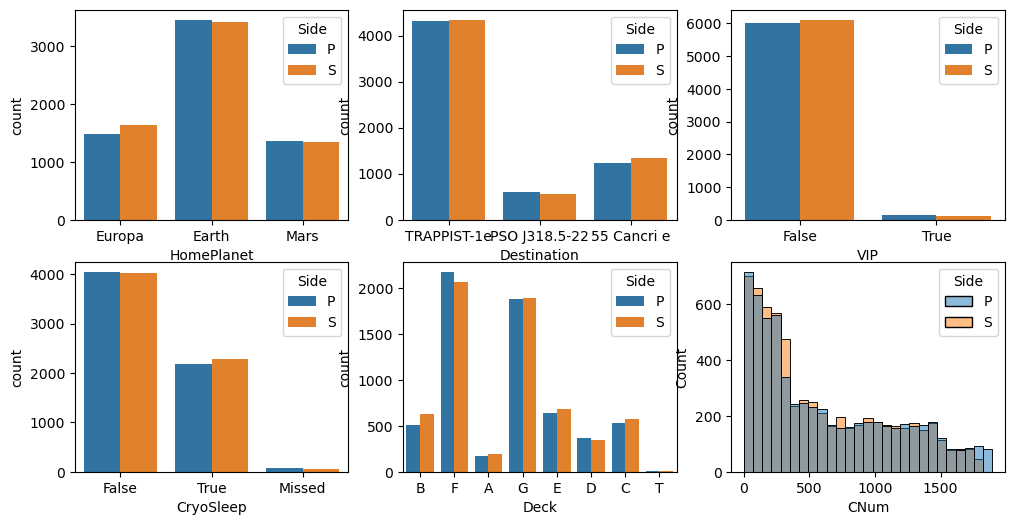

In [35]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
for i, col in enumerate(['HomePlanet', 'Destination', 'VIP', 'CryoSleep', 'Deck']):
    sns.countplot(data=df_all, x=col, hue='Side', ax=axes[i // 3, i % 3])
dfka = parse_base_features(df_all_original)
dfka['CNum'] = dfka['CNum'].astype(float)
sns.histplot(data=dfka, x='CNum', hue='Side', ax=axes[1, 2])

In [36]:
inconsistent = df_all.groupby('Group')['Side'].nunique()
print('Same group - same side:', len(inconsistent[inconsistent == 1]) / len(inconsistent))
inconsistent = df_all.groupby(['Group', 'SName'])['Side'].nunique()
print('Same group and second name - same side:', len(inconsistent[inconsistent == 1]) / len(inconsistent))

Same group - same side: 0.9826508620689656
Same group and second name - same side: 0.9821728187919463


Видим, что как всегда номер группы определяет почти полностью прочие признаки. Гипотеза на последнем графике о том, что номер каюты коррелирует со стороной корабля (например, чётные с одной стороны, нечётные с другой) не подтвердилась.

Номер группы почти идеально определяет сторону корабля, поэтому заполним пропуски только с учётом номера группы.

In [37]:
def fill_side(df_all, df):
    df = df.copy()
    # 1. Заполнение по одинаковым группам
    group_side_map = df_all.groupby('Group')['Side'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0])
    df['Side'] = df['Side'].fillna(df['Group'].map(group_side_map))

    # 2. Глобальная мода
    df['Side'] = df['Side'].fillna('S')
    
    return df

df_train = fill_side(df_all, df_train)
df_test = fill_side(df_all, df_test)
df_all = fill_side(df_all, df_all)

### Cabin

Этот признак уже был разбит на три отдельных, поэтому просто удалим его позже.

In [38]:
#df_train = df_train.drop(columns='Cabin')
#df_test = df_test.drop(columns='Cabin')
#df_all = df_all.drop(columns='Cabin')

### Destination

In [39]:
inconsistent = df_all.groupby('Group')['Destination'].nunique()
print('Same group - same destination:', len(inconsistent[inconsistent == 1]) / len(inconsistent))
inconsistent = df_all.groupby(['Group', 'SName'])['Destination'].nunique()
print('Same group and second name - same destination:', len(inconsistent[inconsistent == 1]) / len(inconsistent))
dfka = parse_base_features(df_all_original)
inconsistent = dfka.groupby('CNum')['Destination'].nunique()
print('Same cabin number - same destination:', len(inconsistent[inconsistent == 1]) / len(inconsistent))

Same group - same destination: 0.868103448275862
Same group and second name - same destination: 0.8800335570469798
Same cabin number - same destination: 0.2692713833157339


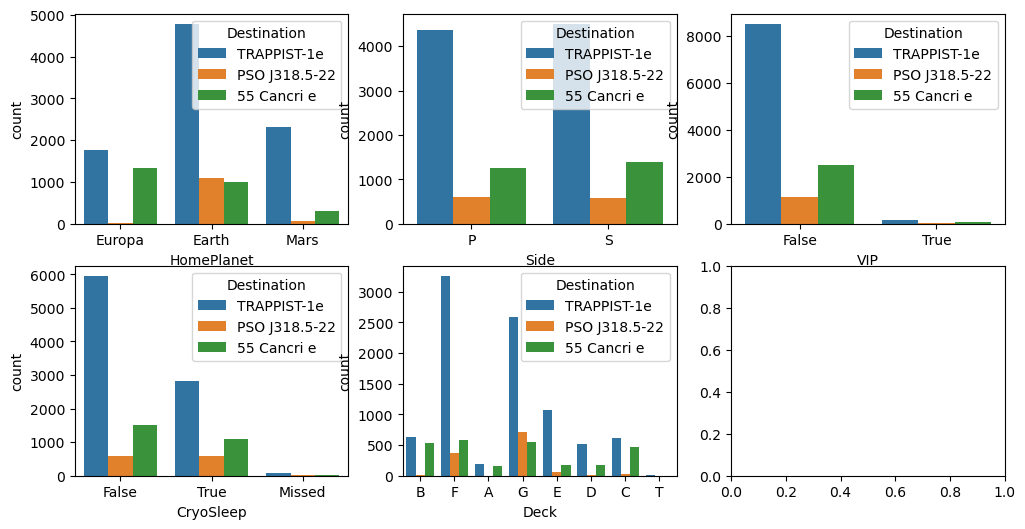

In [40]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
for i, col in enumerate(['HomePlanet', 'Side', 'VIP', 'CryoSleep', 'Deck']):
    sns.countplot(data=df_all, x=col, hue='Destination', ax=axes[i // 3, i % 3])

Никакой связи с другими признаками у места назначения почти нет. В любой колонке можно видеть один и тот же паттерн, который совпадает с общим распредедлением Destination. Поэтому как всегда заполним просто по группе.

Остаток заполнять глобальной модой может оказаться не такой очевидной идеей, как с Side, где распределение тагрета более сбалансировано. Кроме того, здесь совпадение места назначения у людей из одной группы реже встречается. После заполнения по общей группе остаётся еще больше половины пропусков - 154 из 274. Пока что заполню как Missed. Возможно, этого количества для отдельной группы достаточно.

In [41]:
def fill_destination(df_all, df):
    df = df.copy()
    # 1. Заполнение по одинаковым группам
    group_destination_map = df_all.groupby('Group')['Destination'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0])
    df['Destination'] = df['Destination'].fillna(df['Group'].map(group_destination_map))

    # 2. Остатки (154) заполняем Missed
    df['Destination'] = df['Destination'].fillna('Missed')
    
    return df

df_train = fill_destination(df_all, df_train)
df_test = fill_destination(df_all, df_test)
df_all = fill_destination(df_all, df_all)

### Age

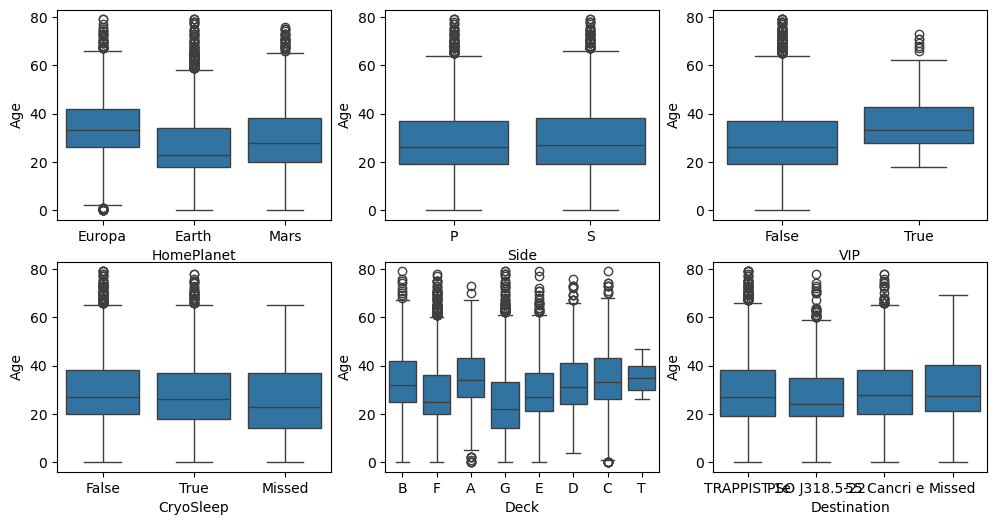

In [42]:
cat_features = ['HomePlanet', 'Side', 'VIP', 'CryoSleep', 'Deck', 'Destination']
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
for i, col in enumerate(cat_features):
    sns.boxplot(data=df_all, x=col, y='Age', ax=axes[i // 3, i % 3])
plt.show()

In [43]:
print(df_all.groupby('Age')['VIP'].any().to_string())

Age
0.0     False
1.0     False
2.0     False
3.0     False
4.0     False
5.0     False
6.0     False
7.0     False
8.0     False
9.0     False
10.0    False
11.0    False
12.0    False
13.0    False
14.0    False
15.0    False
16.0    False
17.0    False
18.0     True
19.0     True
20.0     True
21.0    False
22.0     True
23.0     True
24.0    False
25.0     True
26.0     True
27.0     True
28.0     True
29.0     True
30.0     True
31.0     True
32.0     True
33.0     True
34.0     True
35.0     True
36.0     True
37.0     True
38.0     True
39.0     True
40.0     True
41.0     True
42.0     True
43.0     True
44.0     True
45.0     True
46.0     True
47.0     True
48.0     True
49.0     True
50.0     True
51.0     True
52.0     True
53.0     True
54.0     True
55.0     True
56.0     True
57.0     True
58.0     True
59.0     True
60.0     True
61.0     True
62.0     True
63.0    False
64.0    False
65.0    False
66.0     True
67.0     True
68.0     True
69.0     True
70.0    False
71

Видим, что медиана возраста существенно зависит от VIP и Deck, и немного от HomePlanet. По графику распределения таргета по возрасту в самом начале видим, что примерно с возрастом до 20 лет больше шанс спастись. При этом с помощью кода выше мы увидели, что ВИПы начинают появляться только с 18 лет, значит скорее всего ВИП очень сильно должен помогать заполнять пропуски в возрасте.

Теперь взглянем на зависимость трат от возраста.

<Axes: xlabel='Age', ylabel='TotalSpendings'>

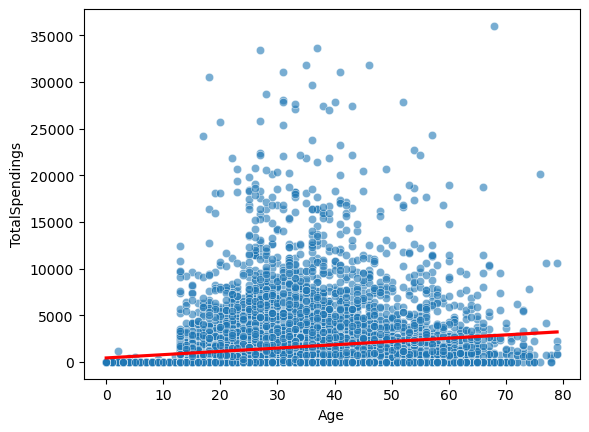

In [44]:
sns.scatterplot(data=df_all, x='Age', y='TotalSpendings', alpha=0.6)
sns.regplot(data=df_all, x='Age', y='TotalSpendings', color='red', scatter=False)

In [45]:
print('Age', '% of 0 spendings', sep='\t')
for i in range(int(df_all['Age'].max()) + 1):
    print(i, len(df_all[(df_all['TotalSpendings'] == 0) & (df_all['Age'] == i)]) / len(df_all[df_all['Age'] == i]) * 100, sep='\t')

Age	% of 0 spendings
0	98.84615384615385
1	98.93617021276596
2	97.27272727272728
3	100.0
4	97.8021978021978
5	98.11320754716981
6	98.46153846153847
7	98.46153846153847
8	98.57142857142858
9	98.4126984126984
10	100.0
11	98.55072463768117
12	98.14814814814815
13	47.03196347031963
14	52.76381909547738
15	47.80701754385965
16	51.598173515981735
17	46.69421487603306
18	36.693548387096776
19	33.62637362637363
20	29.51945080091533
21	33.33333333333333
22	32.378854625550666
23	30.963302752293576
24	29.460580912863072
25	41.35338345864661
26	35.0
27	31.34715025906736
28	36.340206185567006
29	37.05882352941177
30	34.78260869565217
31	35.08771929824561
32	33.44594594594595
33	36.19402985074627
34	40.51724137931034
35	38.768115942028984
36	34.10852713178294
37	32.6530612244898
38	39.38053097345133
39	33.66834170854271
40	37.755102040816325
41	35.82887700534759
42	29.18918918918919
43	35.32608695652174
44	35.79545454545455
45	30.37037037037037
46	40.28776978417266
47	41.66666666666667
48	34.2342342

Видим по графику, что есть точное ограничение, до которого люди не тратят деньги. Проверили его явно, посчитав долю людей, не тратящих деньги в зависимости от возраста, и выяснили, что до 12 лет деньги вообще не тратят. Теперь глянем на то, какой средний разброс возраста внутри одной фамилии (стандартное отклонение).

In [46]:
print(df_all.groupby('SName')['Age'].std().describe())

count    2185.000000
mean       12.273074
std         5.701617
min         0.000000
25%         8.103497
50%        12.206556
75%        16.069169
max        39.597980
Name: Age, dtype: float64


Видим, что среднее стандартное отклонение около 12 лет. Это не очень мало, но все-таки может мы можем использовать медиану по фамилии для заполнения пропусков. Заодно глянем такую же статистику для группировки по палубе.

In [47]:
print(df_all.groupby('Deck')['Age'].std().describe())

count     8.000000
mean     12.605952
std       2.386938
min       7.047888
25%      12.806303
50%      13.148285
75%      13.263267
max      15.309318
Name: Age, dtype: float64


В итоге мы знаем, что:
1. Если Age < 13, то TotalSpendings = 0. В обратную сторону не работает. Можем разделить выборку на несколько бинов, в первый из которых будут входить нулевые траты, а в остальные ненулевые. Сделаем таких несколько бинов, полученных из log(TotalSpendings), так как траты денег всегда растут экспоненциально. Чтобы знать на какие бины разбивать, ниже построим гистограмму TotalSpendings.
2. Если Age < 18, то VIP == False. В обратную сторону не работает. Можем делить выборку на две части по значению ВИП и обрабатывать обе половинки независимо.
3. Медиана возраста зависит от VIP, Deck и HomePlanet. Вообще, эти значения сами по себе весьма связанные. Так, ВИПы обычно не с Земли, а планета определяет на каких палубах окажется пассажир. Получается, что раз уже решили делить выборку на две части по ВИП, можно использовать только палубу.
4. Внутри фамилии стандартное отклонение 12 лет, значит можно использовать её. В то же время люди с одной фамилией часто оказываются на одной палубе, так что как будто нет смысла использовать еще и фамилию.

<Axes: xlabel='TotalSpendings', ylabel='Count'>

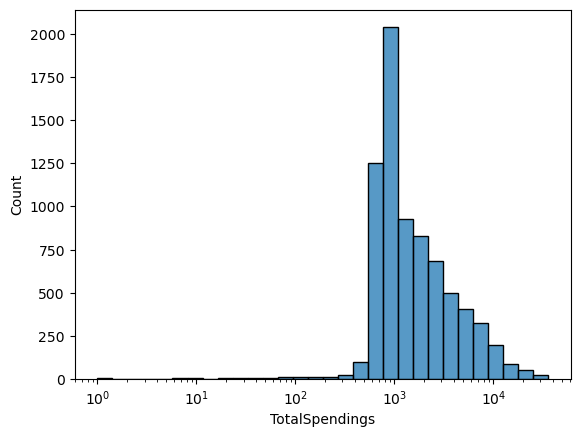

In [48]:
sns.histplot(data=df_all[df_all['TotalSpendings'] > 0], x='TotalSpendings', log_scale=True, bins=30)

In [49]:
def fill_age(df_all, df):
    # По графику я выделил несколько зон, которые будут создавать группы в зависимости от трат
    def spending_bins(x):
        if x == 0:
            return 0 # Не тратили
        if x < 518:
            return 1 # Тратили очень мало
        if x < 1390:
            return 2 # Тратили как большинство
        if x < 10000:
            return 3 # Тратили больше большинства
        return 4 # Тратили больше всех
    
    df = df.copy()
    # 1. Заполняем по трем группам. TotalSpendings уже расписан в функции, а VIP автоматически разделится при группировке
    df['SpendingBins'] = df['TotalSpendings'].apply(spending_bins)
    vds_age_map = df.groupby(['VIP', 'Deck', 'SpendingBins'])['Age'].median()
    key = df[['VIP', 'Deck', 'SpendingBins']].apply(tuple, axis=1)
    df['Age'] = df['Age'].fillna(key.map(vds_age_map))

    # 2. Остаток (9) заполняем медианой по палубе
    deck_age_map = df.groupby('Deck')['Age'].median()
    df['Age'] = df['Age'].fillna(df['Deck'].map(deck_age_map))
    
    return df

df_train = fill_age(df_all, df_train)
df_test = fill_age(df_all, df_test)
df_all = fill_age(df_all, df_all)

### VIP

In [50]:
inconsistent = df_all.groupby('Group')['VIP'].nunique()
print('Same group - same VIP:', len(inconsistent[inconsistent == 1]) / len(inconsistent))
inconsistent = df_all.groupby('SName')['VIP'].nunique()
print('Same second name - same VIP:', len(inconsistent[inconsistent == 1]) / len(inconsistent))
inconsistent = df_all.groupby(['Group', 'SName'])['VIP'].nunique()
print('Same group and second name - same VIP:', len(inconsistent[inconsistent == 1]) / len(inconsistent))
dfka = parse_base_features(df_all_original)
inconsistent = dfka.groupby('CNum')['VIP'].nunique()
print('Same cabin number - same VIP:', len(inconsistent[inconsistent == 1]) / len(inconsistent))

Same group - same VIP: 0.9658405172413793
Same second name - same VIP: 0.899833748960931
Same group and second name - same VIP: 0.9677013422818792
Same cabin number - same VIP: 0.8880675818373812


Видим, что люди из одной группы почти наверняка совпадают по статусу ВИП. Фамилия и номер кабины тоже уже говорят о многом. Можно уже с этим знанием заполнить пропуски, но для интереса глянем на графики зависимости от категориальных признаков. Причем, смотреть как обычно на распределение всех значений признака нам не интересно - все графики будут иметь большие столбцы False и маленькие True. Это неудобно, ничего не будет понятно, поэтому будем строить только для значений True.

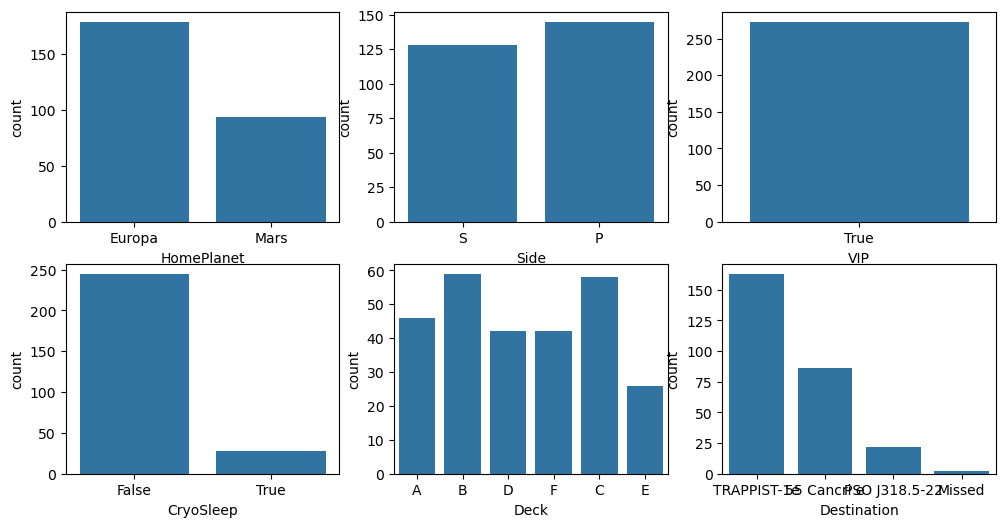

In [51]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
for i, col in enumerate(cat_features):
    sns.countplot(data=df_all[df_all['VIP'] == True], x=col, ax=axes[i // 3, i % 3])
plt.show()

<Axes: xlabel='TotalSpendings', ylabel='Count'>

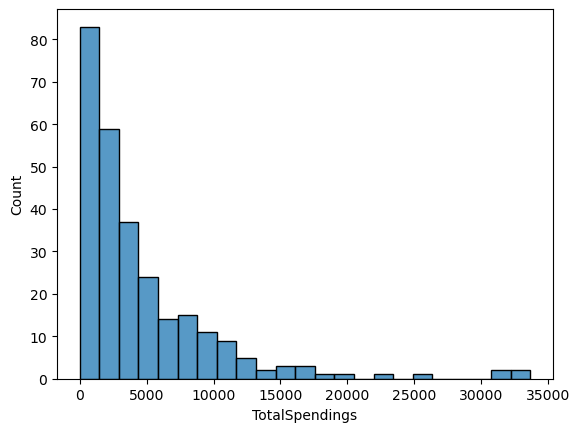

In [52]:
sns.histplot(data=df_all[df_all['VIP'] == True], x='TotalSpendings')

Как видим, нашлось **правило** - на Земле нет ВИПов. И еще ВИПы часто не в криосне. А вот предположение о том, что ВИПы много тратят денег оказалось неверным.

In [53]:
def fill_vip(df_all, df):
    df = df.copy()
    # 1. Все земляне не ВИП
    df.loc[df['HomePlanet'] == 'Earth', 'VIP'] = False

    # 2. Заполняем модой по группе
    group_vip_map = df_all.groupby('Group')['VIP'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0])
    df['VIP'] = df['VIP'].fillna(df['Group'].map(group_vip_map))

    # 3. Заполняем модой по криосну
    cryosleep_vip_map = df_all.groupby('CryoSleep')['VIP'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0])
    df['VIP'] = df['VIP'].fillna(df['CryoSleep'].map(cryosleep_vip_map))

    return df

df_train = fill_vip(df_all, df_train)
df_test = fill_vip(df_all, df_test)
df_all = fill_vip(df_all, df_all)

C:\Users\Dantesto\AppData\Local\Temp\ipykernel_15472\291582256.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['VIP'] = df['VIP'].fillna(df['CryoSleep'].map(cryosleep_vip_map))
C:\Users\Dantesto\AppData\Local\Temp\ipykernel_15472\291582256.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['VIP'] = df['VIP'].fillna(df['CryoSleep'].map(cryosleep_vip_map))
C:\Users\Dantesto\AppData\Local\Temp\ipykernel_15472\291582256.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future vers

### Name, FName, SName

Name и FName позже удалим.

Если не обрабатывать фамилии с помощью target-encoding, программа очень долго будет обрабатывать фамилии, их больше, чем даже групп, которые тоже с эту проблему создают. Думаю для простоты можно было бы просто заполнить фамилии как пропущенные значения, но я этого делать не буду, так как в будущем просто удалю этот признак.

In [54]:
#df_train = df_train.drop(columns=['Name', 'FName'])
#df_test = df_test.drop(columns=['Name', 'FName'])
#df_all = df_all.drop(columns=['Name', 'FName'])

In [55]:
'''
def fill_sname(df):
    df = df.copy()
    df['SName'] = df['SName'].fillna('Missed')

    return df

df_train = fill_sname(df_train)
df_test = fill_sname(df_test)
df_all = fill_sname(df_all)
'''

"\ndef fill_sname(df):\n    df = df.copy()\n    df['SName'] = df['SName'].fillna('Missed')\n\n    return df\n\ndf_train = fill_sname(df_train)\ndf_test = fill_sname(df_test)\ndf_all = fill_sname(df_all)\n"

## Feature engineering

In [56]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PassengerId     12970 non-null  object 
 1   HomePlanet      12970 non-null  object 
 2   CryoSleep       12970 non-null  object 
 3   Cabin           12671 non-null  object 
 4   Destination     12970 non-null  object 
 5   Age             12970 non-null  float64
 6   VIP             12970 non-null  bool   
 7   RoomService     12970 non-null  float64
 8   FoodCourt       12970 non-null  float64
 9   ShoppingMall    12970 non-null  float64
 10  Spa             12970 non-null  float64
 11  VRDeck          12970 non-null  float64
 12  Name            12676 non-null  object 
 13  Transported     8693 non-null   object 
 14  Group           12970 non-null  object 
 15  GNum            12970 non-null  object 
 16  Deck            12970 non-null  object 
 17  CNum            12671 non-null 

Удалим GNum и SpendingBins. Конечно, SpendingBins может быть полезным, но модели и сами создадут нужные разбиения. Разве что можно создать бинарный признак HadSpendings. С другой стороны, программа и так может понять были ли разденеления с помощью TotalSpendings.

In [57]:
df_train = df_train.drop(columns=['GNum', 'SpendingBins'])
df_test = df_test.drop(columns=['GNum', 'SpendingBins'])
df_all = df_all.drop(columns=['GNum', 'SpendingBins'])

### Работа с Group, Name, Cabin

Все признаки с тратами можно было бы логарифмически преобразовать, но так как я работаю только с деревьями, это не важно.

Хотелось бы не удалять признаки Group и SName, ведь если у двух пассажиров они совпадают, то скорее всего они из одной семьи, а значит имеют примерно равные шансы на выживание. Но мы не можем оставить Group как числовой признак, так как его порядковое значение не влияет на таргет, и не можем сделать его категориальным, так как уникальных категорий больше половины всех строк. А еще, появление новых групп в реальной задаче создадут проблемы при их обработке, так как во время обучения деревья не сталкивались с ними.

По сути, если оставлять Group и SName как категориальные признаки, мы обучим модель на конркетно на присутсвующих значениях в тренировочных данных. Новые фамилии и группы будут в лучшем случае просто не учитываться деревьями, восприниматься как пропуски. И это при том, что в тренировочных данных нет пропусков.

Поводом не волноваться об удалении Group и SName может выступать то, что мы уже, заполняя пропуски, увидели, что прочие признаки с одинаковыми группами и фамилиями сильно совпадают. То есть уже другие признаки показывают, что строки похожи между собой.

Однако до удаления, мы можем создать агрегированый признак на основе Group - GroupSize. Такой же создавать на основе SName не будем, так как люди с одинаковыми фамилиями могут быть не связаны никак, но можно создать признак на основе пары (Group, SName), и тогда мы будем уверены, что это люди из одной семьи. Так мы сделаем FamilySize. И аналогично сделаем CabinSize.

In [58]:
def make_size_cols(df_all, df):
    df = df.copy()
    
    group_groupsize_map = df_all.groupby('Group')['PassengerId'].size().to_dict()
    df['GroupSize'] = df['Group'].map(group_groupsize_map)

    gs_familysize_map = df_all.groupby(['Group', 'SName'])['PassengerId'].size().to_dict()
    df['FamilySize'] = df[['Group', 'SName']].apply(tuple, axis=1)
    df['FamilySize'] = df['FamilySize'].map(gs_familysize_map)
    df['FamilySize'] = df['FamilySize'].where(df['SName'].notna(), -1)
    # Заполнили пропуски так, а не через fillna, так как gs_familysize_map содержит на месте пропусков значение 1,
    # то есть после map в FamilySize не будет пропусков

    cabin_cabinsize_map = df_all.groupby('Cabin')['PassengerId'].size().to_dict()
    df['CabinCapacity'] = df['Cabin'].map(cabin_cabinsize_map)
    df['CabinCapacity'] = df['CabinCapacity'].where(df['Cabin'].notna(), -1)

    return df

df_train = make_size_cols(df_all, df_train)
df_test = make_size_cols(df_all, df_test)
df_all = make_size_cols(df_all, df_all)

In [59]:
df_train = df_train.drop(columns=['Group', 'Name', 'FName', 'SName', 'Cabin', 'CNum'])
df_test = df_test.drop(columns=['Group', 'Name', 'FName', 'SName', 'Cabin', 'CNum'])
df_all = df_all.drop(columns=['Group', 'Name', 'FName', 'SName', 'Cabin', 'CNum'])

Покажем, что какая-то зависимость от размера группы, семьи и количества людей в каюте существует на графиках.

<Axes: xlabel='GroupSize', ylabel='count'>

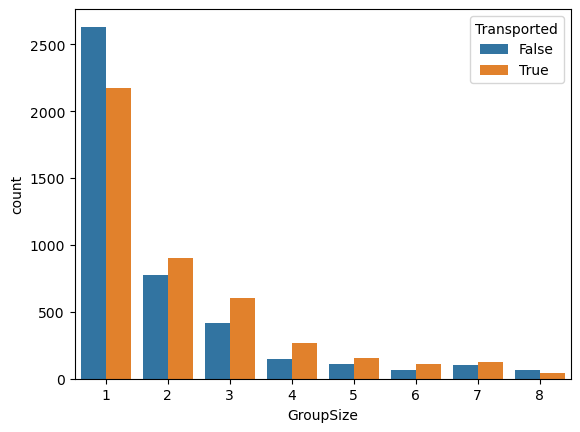

In [60]:
sns.countplot(data=df_all, x='GroupSize', hue='Transported')

<Axes: xlabel='FamilySize', ylabel='count'>

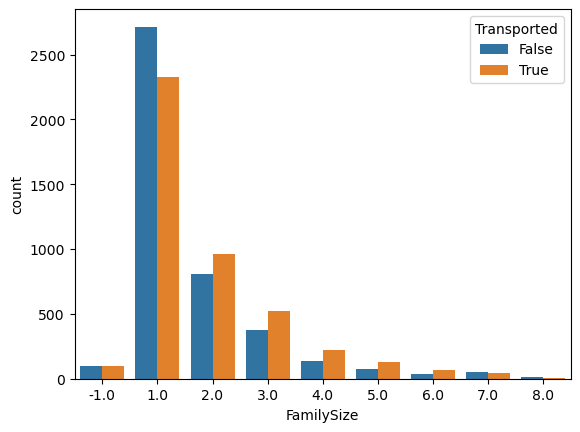

In [61]:
sns.countplot(data=df_all, x='FamilySize', hue='Transported')

<Axes: xlabel='CabinCapacity', ylabel='count'>

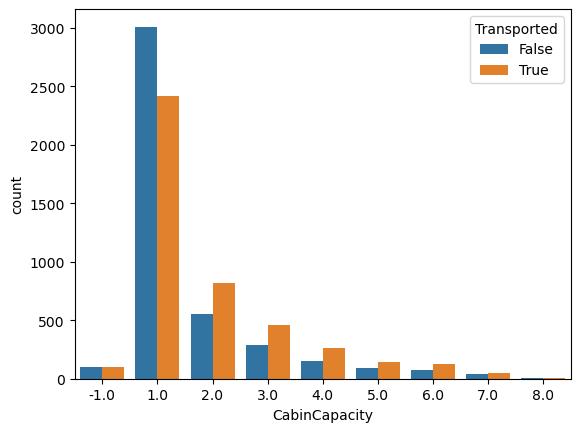

In [62]:
sns.countplot(data=df_all, x='CabinCapacity', hue='Transported')

### Работа с тратами

В самом начале мы заметили, что при увеличении трат на RoomService, Spa и VRDeck уменьшаяется шанс выжить, а при увеличении трат на FoodCourt и ShoppingMall шансы выжить увеличиваются. У этих групп есть логическая связь: первая группа - это траты на приватные услуги, а вторая группа - траты на публичные услуги.

Это дает повод нам объединить траты в две новые колонки.

In [63]:
def make_spending_cols(df):
    df = df.copy()

    df['PrivateSpending'] = df['RoomService'] + df['Spa'] + df['VRDeck']
    df['PublicSpending'] = df['FoodCourt'] + df['ShoppingMall']

    return df

df_train = make_spending_cols(df_train)
df_test = make_spending_cols(df_test)
df_all = make_spending_cols(df_all)

# Решение

## Модель после обработок

In [64]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PassengerId      12970 non-null  object 
 1   HomePlanet       12970 non-null  object 
 2   CryoSleep        12970 non-null  object 
 3   Destination      12970 non-null  object 
 4   Age              12970 non-null  float64
 5   VIP              12970 non-null  bool   
 6   RoomService      12970 non-null  float64
 7   FoodCourt        12970 non-null  float64
 8   ShoppingMall     12970 non-null  float64
 9   Spa              12970 non-null  float64
 10  VRDeck           12970 non-null  float64
 11  Transported      8693 non-null   object 
 12  Deck             12970 non-null  object 
 13  Side             12970 non-null  object 
 14  TotalSpendings   12970 non-null  float64
 15  GroupSize        12970 non-null  int64  
 16  FamilySize       12970 non-null  float64
 17  CabinCapacit

In [65]:
cat_features

['HomePlanet', 'Side', 'VIP', 'CryoSleep', 'Deck', 'Destination']

In [66]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(random_seed=42, verbose=100, iterations=1000, cat_features=cat_features, loss_function='Logloss', eval_metric='Accuracy')
model.fit(df_train.drop(columns=['PassengerId', 'Transported']), df_train['Transported'], use_best_model=True, eval_set=(df_train.drop(columns=['PassengerId', 'Transported']), df_train['Transported']))

Learning rate set to 0.054061
0:	learn: 0.7801680	test: 0.7801680	best: 0.7801680 (0)	total: 188ms	remaining: 3m 7s
100:	learn: 0.8144484	test: 0.8149085	best: 0.8149085 (100)	total: 2.56s	remaining: 22.8s
200:	learn: 0.8256068	test: 0.8238813	best: 0.8238813 (199)	total: 4.93s	remaining: 19.6s
300:	learn: 0.8351547	test: 0.8331991	best: 0.8333142 (299)	total: 7.4s	remaining: 17.2s
400:	learn: 0.8456229	test: 0.8394110	best: 0.8399862 (399)	total: 9.9s	remaining: 14.8s
500:	learn: 0.8573565	test: 0.8483838	best: 0.8484988 (497)	total: 12.4s	remaining: 12.4s
600:	learn: 0.8658691	test: 0.8563212	best: 0.8563212 (600)	total: 15s	remaining: 9.93s
700:	learn: 0.8740366	test: 0.8640285	best: 0.8640285 (700)	total: 17.5s	remaining: 7.47s
800:	learn: 0.8787530	test: 0.8681698	best: 0.8682848 (792)	total: 20s	remaining: 4.97s
900:	learn: 0.8851950	test: 0.8721960	best: 0.8723111 (885)	total: 22.5s	remaining: 2.47s
999:	learn: 0.8919821	test: 0.8777177	best: 0.8777177 (996)	total: 25s	remaining

In [67]:
from sklearn.metrics import accuracy_score

print(accuracy_score(df_train['Transported'], model.predict(df_train.drop(columns=['PassengerId', 'Transported']))))

0.8777177038996894


In [68]:
predictions = model.predict(df_test.drop(columns='PassengerId'))

In [69]:
submission = pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Transported': predictions})
submission.to_csv('cb_submission.csv', index=False)

Результат 0.80243 для 1000 итераций и 0.80102 для 10000.

Взглянем на важность признаков.

In [70]:
importances = model.feature_importances_
feature_names = df_train.drop(columns=['PassengerId', 'Transported']).columns

import pandas as pd
feat_imp = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

print(feat_imp)

            feature  importance
16  PrivateSpending   17.417686
0        HomePlanet   13.378904
10             Deck   12.288183
3               Age    8.613471
12   TotalSpendings    6.682664
1         CryoSleep    6.341290
17   PublicSpending    5.386109
2       Destination    4.215906
8               Spa    4.153817
11             Side    4.145878
6         FoodCourt    3.613138
7      ShoppingMall    3.223315
5       RoomService    3.154562
9            VRDeck    2.806669
14       FamilySize    1.693493
15    CabinCapacity    1.567774
13        GroupSize    1.183764
4               VIP    0.133379


### Улучшаем модель

Посмотрим на строки, где модель ошибается.

In [71]:
errors = df_train.loc[df_train['Transported'] != model.predict(df_train.drop(columns=['PassengerId', 'Transported']))].copy()
errors['Predictions'] = model.predict(errors.drop(columns=['PassengerId', 'Transported']))

In [72]:
print('% of errors:', len(errors) / len(df_train) * 100)
print('FP:', (errors['Predictions'] == True).sum())
print('FN:', (errors['Predictions'] == False).sum())

% of errors: 12.22822961003106
FP: 606
FN: 457


Посмотрим на распределение ошибок и всех данных.

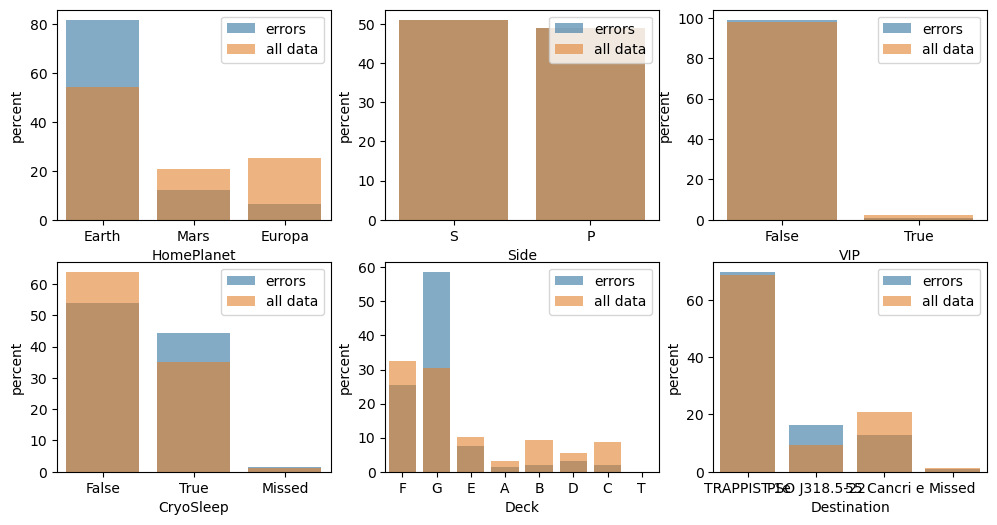

In [73]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
for num, col in enumerate(cat_features):
    sns.countplot(data=errors, x=col, ax=axes[num // 3, num % 3], label='errors', alpha=0.6, stat='percent')
    sns.countplot(data=df_train, x=col, ax=axes[num // 3, num % 3], label='all data', alpha=0.6, stat='percent')
plt.show()

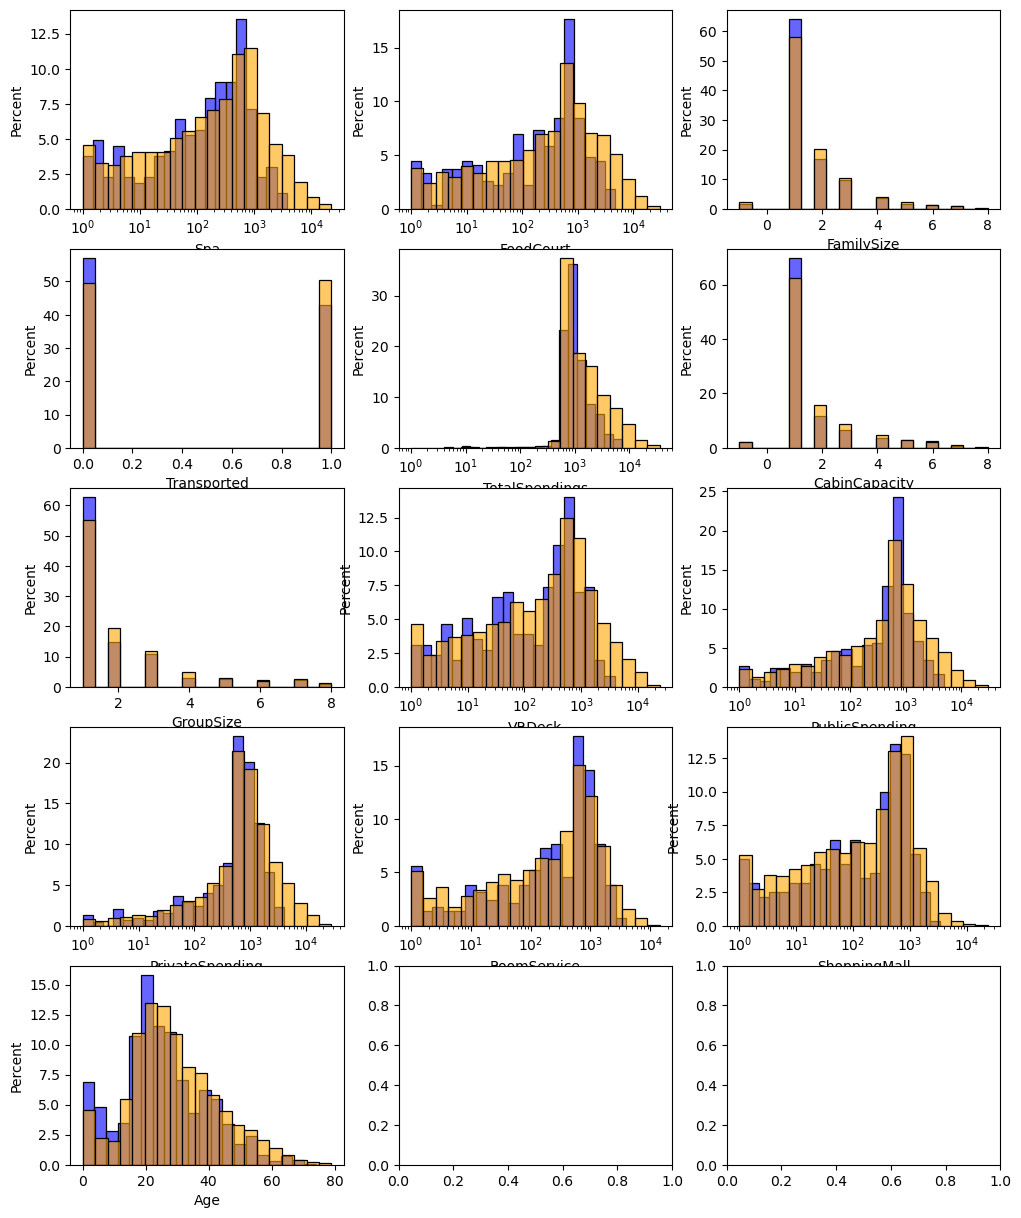

In [74]:
num_features = set(df_train.columns.to_list()) - set(cat_features) - {'PassengerId'}
full_spending_features = spending_features + ['TotalSpendings', 'PublicSpending', 'PrivateSpending']

fig, axes = plt.subplots(5, 3, figsize=(12, 15))
for num, col in enumerate(num_features):
    sns.histplot(data=errors, x=col, bins=20, ax=axes[num // 3, num % 3], label='errors', alpha=0.6, stat='percent', color='blue', log_scale=True if col in full_spending_features else False)
    sns.histplot(data=df_train, x=col, bins=20, ax=axes[num // 3, num % 3], label='all data', alpha=0.6, stat='percent', color='orange', log_scale=True if col in full_spending_features else False)
plt.show()

Мы наблюдаем, что наиболее частые ошибки возникают при HomePlanet = Earth и Deck = G. На палубе G находятся только земляне, значит, решив проблему с G, мы скорее всего решим проблему с Землей.

In [75]:
print('Precision on HomePlanet=Earth:', 1 - errors['HomePlanet'].value_counts()['Earth'] / df_train['HomePlanet'].value_counts()['Earth'])
print('Precision on Deck=G:', 1 - errors['Deck'].value_counts()['G'] / df_train['Deck'].value_counts()['G'])

Precision on HomePlanet=Earth: 0.8157894736842105
Precision on Deck=G: 0.764172335600907


In [76]:
df_train[df_train['Deck'] == 'G']['Transported'].value_counts(normalize=True)

Transported
True     0.51285
False    0.48715
Name: proportion, dtype: float64

In [77]:
model2 = CatBoostClassifier(random_seed=42, verbose=100, iterations=1000, cat_features=cat_features, loss_function='Logloss', eval_metric='Accuracy')
model2.fit(errors.drop(columns=['PassengerId', 'Transported', 'Predictions']), errors['Transported'], use_best_model=True, eval_set=(errors.drop(columns=['PassengerId', 'Transported', 'Predictions']), errors['Transported']))

Learning rate set to 0.032171
0:	learn: 0.8927563	test: 0.8927563	best: 0.8927563 (0)	total: 16.8ms	remaining: 16.8s
100:	learn: 0.9501411	test: 0.9501411	best: 0.9501411 (100)	total: 1.81s	remaining: 16.1s
200:	learn: 0.9670743	test: 0.9623706	best: 0.9642521 (189)	total: 3.55s	remaining: 14.1s
300:	learn: 0.9783631	test: 0.9774224	best: 0.9774224 (298)	total: 5.33s	remaining: 12.4s
400:	learn: 0.9849483	test: 0.9793039	best: 0.9793039 (327)	total: 7.16s	remaining: 10.7s
500:	learn: 0.9924741	test: 0.9830668	best: 0.9830668 (500)	total: 8.97s	remaining: 8.94s
600:	learn: 0.9971778	test: 0.9877705	best: 0.9877705 (590)	total: 10.8s	remaining: 7.17s
700:	learn: 0.9971778	test: 0.9896519	best: 0.9896519 (675)	total: 12.6s	remaining: 5.38s
800:	learn: 0.9971778	test: 0.9905927	best: 0.9905927 (725)	total: 14.4s	remaining: 3.59s
900:	learn: 0.9981185	test: 0.9915334	best: 0.9915334 (827)	total: 16.3s	remaining: 1.79s
999:	learn: 0.9990593	test: 0.9915334	best: 0.9915334 (827)	total: 18.1s	

<Axes: ylabel='Count'>

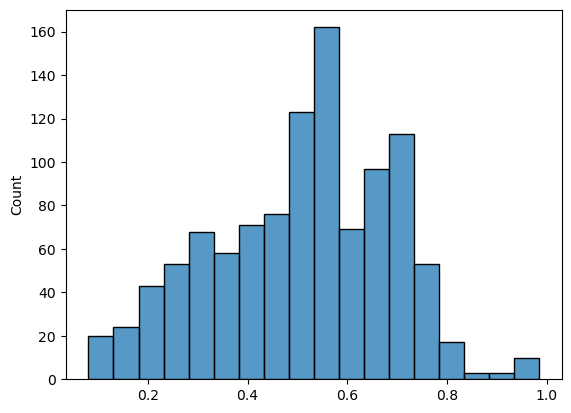

In [78]:
sns.histplot(model.predict_proba(errors.drop(columns=['Transported', 'PassengerId', 'Predictions']))[:, 1])

In [79]:
def make_meta_data(df, errors):
    df = df.copy()
    errors_id = set(errors['PassengerId'])
    df['BestModel'] = df.apply(lambda row: 1 if row['PassengerId'] in errors_id else 0, axis=1)
    return df

df_train_meta = make_meta_data(df_train, errors)

In [80]:
df_train_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PassengerId      8693 non-null   object 
 1   HomePlanet       8693 non-null   object 
 2   CryoSleep        8693 non-null   object 
 3   Destination      8693 non-null   object 
 4   Age              8693 non-null   float64
 5   VIP              8693 non-null   bool   
 6   RoomService      8693 non-null   float64
 7   FoodCourt        8693 non-null   float64
 8   ShoppingMall     8693 non-null   float64
 9   Spa              8693 non-null   float64
 10  VRDeck           8693 non-null   float64
 11  Transported      8693 non-null   bool   
 12  Deck             8693 non-null   object 
 13  Side             8693 non-null   object 
 14  TotalSpendings   8693 non-null   float64
 15  GroupSize        8693 non-null   int64  
 16  FamilySize       8693 non-null   float64
 17  CabinCapacity 

In [81]:
meta_model = CatBoostClassifier(random_seed=42, verbose=100, iterations=1000, cat_features=cat_features, loss_function='CrossEntropy', eval_metric='Accuracy')
meta_model.fit(df_train_meta.drop(columns=['Transported', 'PassengerId', 'BestModel']), df_train_meta['BestModel'])

0:	learn: 0.8777177	total: 22.4ms	remaining: 22.4s
100:	learn: 0.8777177	total: 1.97s	remaining: 17.6s
200:	learn: 0.8777177	total: 4.06s	remaining: 16.1s
300:	learn: 0.8777177	total: 6.21s	remaining: 14.4s
400:	learn: 0.8781778	total: 8.53s	remaining: 12.7s
500:	learn: 0.8786380	total: 10.9s	remaining: 10.8s
600:	learn: 0.8789831	total: 13.2s	remaining: 8.78s
700:	learn: 0.8802485	total: 15.6s	remaining: 6.65s
800:	learn: 0.8811688	total: 18.1s	remaining: 4.49s
900:	learn: 0.8824341	total: 20.5s	remaining: 2.25s
999:	learn: 0.8843897	total: 22.8s	remaining: 0us


In [82]:
importances = meta_model.feature_importances_
feature_names = df_train_meta.drop(columns=['PassengerId', 'Transported', 'BestModel']).columns

import pandas as pd
feat_imp = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

print(feat_imp)

            feature  importance
0        HomePlanet   16.317795
3               Age   11.364792
12   TotalSpendings    9.131022
10             Deck    7.994133
16  PrivateSpending    7.711120
1         CryoSleep    5.927605
8               Spa    5.554390
2       Destination    4.947549
9            VRDeck    4.867217
17   PublicSpending    4.821691
5       RoomService    4.547955
7      ShoppingMall    4.319117
6         FoodCourt    3.870686
11             Side    2.689110
14       FamilySize    2.439082
13        GroupSize    1.863812
15    CabinCapacity    1.384694
4               VIP    0.248230


In [83]:
def meta_predictions(df_meta, meta_model, model, model2):
    model_to_use = meta_model.predict(df_meta.drop(columns=['PassengerId', 'BestModel']))
    predictions = model.predict(df_meta.drop(columns=['PassengerId', 'BestModel']))
    #predictions[model_to_use == 1] = model2.predict(df_meta[model_to_use == 1].drop(columns=['PassengerId', 'BestModel']))
    predictions[model_to_use == 1] = ~predictions[model_to_use == 1]
    return predictions

predictions = meta_predictions(make_meta_data(df_test, errors), meta_model, model, model2)
#print(accuracy_score(predictions, df_train['Transported']))

In [84]:
submission = pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Transported': predictions})
submission.to_csv('cb2_submission.csv', index=False)

In [94]:
df_train_eg = df_train[df_train['Deck'] == 'G']
df_test_eg = df_test[df_test['Deck'] == 'G']

In [96]:
model2_eg = CatBoostClassifier(random_seed=42, verbose=100, iterations=3000, cat_features=cat_features, loss_function='Logloss', eval_metric='Accuracy')
model2_eg.fit(df_train_eg.drop(columns=['Transported', 'PassengerId']), df_train_eg['Transported'])

Learning rate set to 0.0057
0:	learn: 0.6817838	total: 19.4ms	remaining: 58.1s
100:	learn: 0.6904762	total: 1.78s	remaining: 51.1s
200:	learn: 0.7048375	total: 3.59s	remaining: 50s
300:	learn: 0.7097506	total: 5.41s	remaining: 48.5s
400:	learn: 0.7150416	total: 7.21s	remaining: 46.7s
500:	learn: 0.7154195	total: 9s	remaining: 44.9s
600:	learn: 0.7184429	total: 10.8s	remaining: 43.1s
700:	learn: 0.7214664	total: 12.6s	remaining: 41.3s
800:	learn: 0.7229781	total: 14.4s	remaining: 39.5s
900:	learn: 0.7252457	total: 16.1s	remaining: 37.6s
1000:	learn: 0.7286470	total: 17.9s	remaining: 35.8s
1100:	learn: 0.7297808	total: 19.7s	remaining: 34s
1200:	learn: 0.7312925	total: 21.5s	remaining: 32.2s
1300:	learn: 0.7350718	total: 23.3s	remaining: 30.4s
1400:	learn: 0.7384732	total: 25.1s	remaining: 28.6s
1500:	learn: 0.7422525	total: 26.9s	remaining: 26.8s
1600:	learn: 0.7430083	total: 28.6s	remaining: 25s
1700:	learn: 0.7482993	total: 30.5s	remaining: 23.3s
1800:	learn: 0.7509448	total: 32.4s	re

In [101]:
errors2_eg = df_train_eg.loc[df_train_eg['Transported'] != model2_eg.predict(df_train_eg.drop(columns=['PassengerId', 'Transported']))].copy()
errors2_eg['Predictions'] = model2_eg.predict(errors2_eg.drop(columns=['PassengerId', 'Transported']))

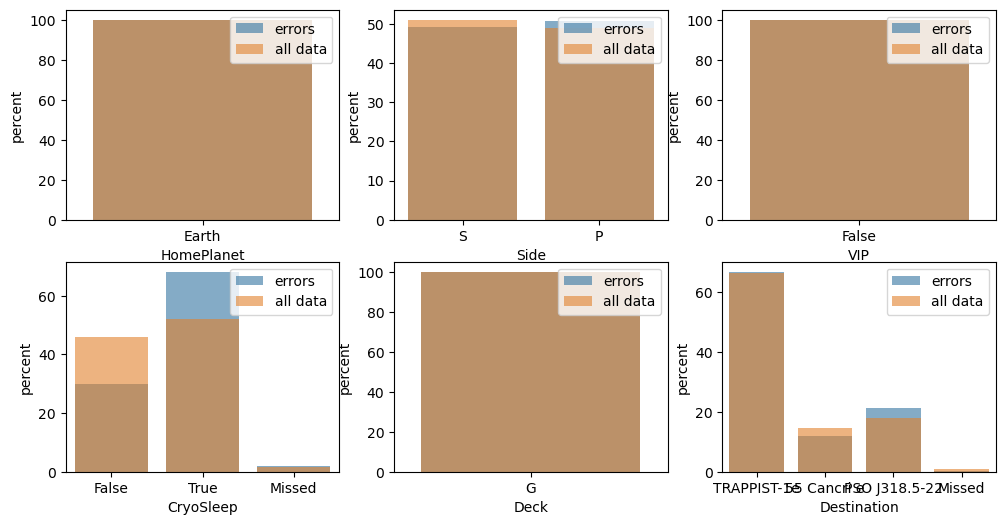

In [102]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
for num, col in enumerate(cat_features):
    sns.countplot(data=errors2_eg, x=col, ax=axes[num // 3, num % 3], label='errors', alpha=0.6, stat='percent')
    sns.countplot(data=df_train_eg, x=col, ax=axes[num // 3, num % 3], label='all data', alpha=0.6, stat='percent')
plt.show()

In [99]:
def meta_predictions2(df_test, model, model2_eg):
    predictions = model.predict(df_test.drop(columns=['PassengerId']))
    predictions[df_test['Deck'] == 'G'] = model2_eg.predict(df_test[df_test['Deck'] == 'G'].drop(columns=['PassengerId']))
    return predictions

predictions = meta_predictions2(df_test, model, model2_eg)

In [100]:
submission = pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Transported': predictions})
submission.to_csv('cb2eg_submission.csv', index=False)

In [85]:
from sklearn.neighbors import KNeighborsClassifier

meta_knn = KNeighborsClassifier()
meta_knn.fit(df_train_meta.drop(columns=['Transported', 'PassengerId', 'BestModel']), df_train_meta['BestModel'])

ValueError: could not convert string to float: 'Europa'

## Модель без обработок

Посмотрим какой результат можно получить, не обрабатывая никак данные.

In [ ]:
df_all_original.info()

In [ ]:
cat_features_original = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

In [ ]:
model_base = CatBoostClassifier(random_seed=42, verbose=100, iterations=1000, cat_features=cat_features_original, loss_function='Logloss', eval_metric='Accuracy')
model_base.fit(df_train_original.drop(columns=['PassengerId', 'Cabin', 'Name', 'Transported']).fillna(-999), df_train_original['Transported'], use_best_model=True)

In [ ]:
print(accuracy_score(df_train_original['Transported'], model_base.predict(df_train_original.drop(columns=['PassengerId', 'Cabin', 'Name', 'Transported']).fillna(-999))))

In [ ]:
predictions = model_base.predict(df_test_original.drop(columns=['PassengerId', 'Cabin', 'Name']).fillna(-999))

In [ ]:
submission = pd.DataFrame({'PassengerId': df_test_original['PassengerId'], 'Transported': predictions})
submission.to_csv('cb_base_submission.csv', index=False)

Результат 0.79471.

То есть многочисленные старания и подготовка данных дали прирост меньше процента. Теперь взглянем на важность признаков.

In [ ]:
importances = model_base.feature_importances_
feature_names = df_train_original.drop(columns=['PassengerId', 'Cabin', 'Name', 'Transported']).columns

import pandas as pd
feat_imp = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

print(feat_imp)